In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preparing Notebook: Adding directory to path so it's possible to import scripts

In [2]:
import sys
def GetRoot(user = None):
    '''
    Deterimines what the root path is for google collab.
    Inputs:
    user (str): Name of the person using this notebook.

    Output:
    (str) root path
    '''
    if user.lower() == 'jackie':
        root = '/content/drive/MyDrive/AUTOMATION/DarthImputer(AutomationProject)'
    elif user.lower() == 'thomas':
        root = '/content/drive/MyDrive/Colab Notebooks/DarthImputer(AutomationProject)'
    elif user.lower() == 'gabe':
        root = '/content/drive/MyDrive/DarthImputer(AutomationProject)'
    else:
        raise Exception("Ya fucked up son. Who are you?")

    return root

root = GetRoot('Thomas')
sys.path.append(f'{root}/src')

In [3]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import helpers
import basic_impute
import mice
import ImputationPipeline
import basemodel
import expected_risk_imputation

In [ ]:
importlib.reload(mice)
importlib.reload(helpers)
importlib.reload(basic_impute)
importlib.reload(ImputationPipeline)
importlib.reload(basemodel)
importlib.reload(expected_risk_imputation)

<module 'expected_risk_imputation' from '/content/drive/MyDrive/Colab Notebooks/DarthImputer(AutomationProject)/src/expected_risk_imputation.py'>

# Step 0: Importing the data

In [4]:
import pandas as pd

# Brain
def ReadData(root, dataset = None):
  """
  Input:
    root (str): Path to the root of the project
    dataset (str): Which data set are you using? "brain","lung" or "breast"
  """

  if dataset.lower() == 'brain':
    path = root + '/data/brain/Brain_GSE50161.csv'
  elif dataset.lower() == 'breast':
    path = root + '/data/breast/Breast_GSE45827.csv'
  elif dataset.lower() == 'lung':
    path = root + '/data/lung/clean/complete_dataframe.csv'
  else:
    raise Exception("I don't have that dataset you ding dong.")

  data = pd.read_csv(path)
  return data

In [5]:
brain_df = ReadData(root, 'brain')
print(brain_df.shape)

(130, 54677)


In [ ]:
breast_df = ReadData(root, 'breast')
print(breast_df.shape)

(151, 54677)


In [ ]:
lung_df = ReadData(root, 'lung')
print(lung_df.shape)

<ipython-input-4-f51855cd090b>:20: DtypeWarning: Columns (22309) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


(442, 22313)


In [7]:
all_labels = helpers.EncodeLabels(brain_df['type'].to_numpy())
# np.save(f'{root}/data/brain/labels.npy', all_labels)
data = brain_df.iloc[:, 2:].to_numpy() # Numpy arr of the features

In [ ]:
proportion = 5000/brain_df.shape[1]
highest_var_features = helpers.HighestVarianceFeatures(data, proportion)
np.save(f'{root}/data/brain/brain_5000.npy', highest_var_features)

Percentage of explained variance is: 0.38625112722391125


# Visualize highest variance feature distribution.

Plot PCA

In [16]:
!pip3 install ipympl
from mpl_toolkits.mplot3d import Axes3D
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget


Percentage of explained variance is: 0.40019402006410365


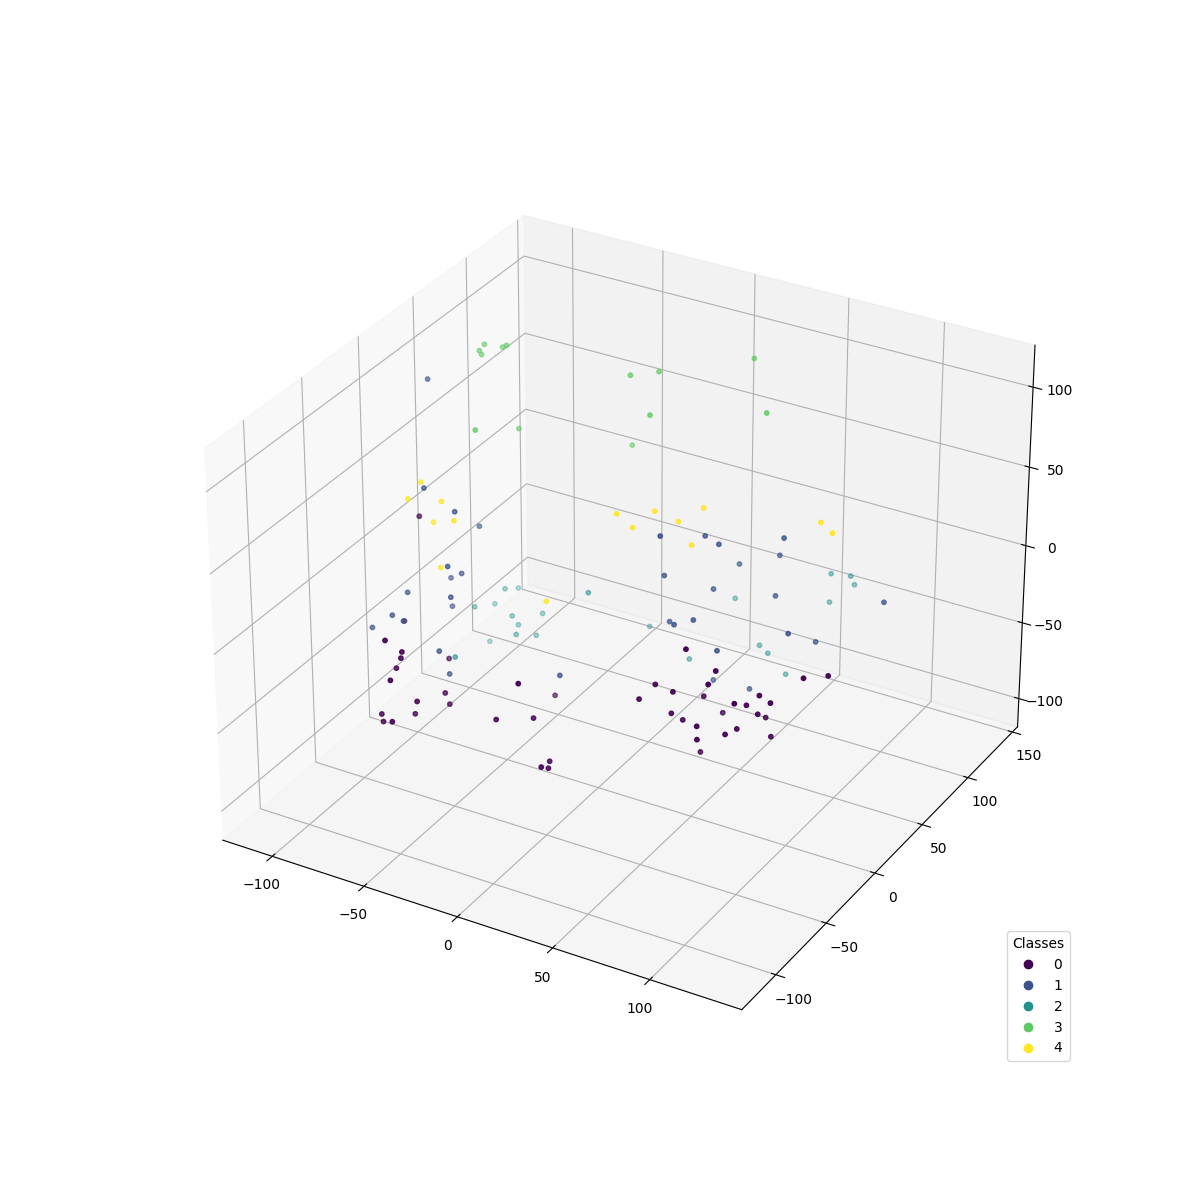

In [18]:
proportion = 3/brain_df.shape[1]
highest_var_features_pca = helpers.HighestVarianceDecomposition(data, proportion)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(highest_var_features_pca[:, 0],
                      highest_var_features_pca[:, 1],
                      highest_var_features_pca[:, 2],
                      c = all_labels, s = 10)
ax.legend(*scatter.legend_elements(), loc="lower right", title="Classes")
plt.show(fig)

Plot histograms of highest variance features (not pca features)

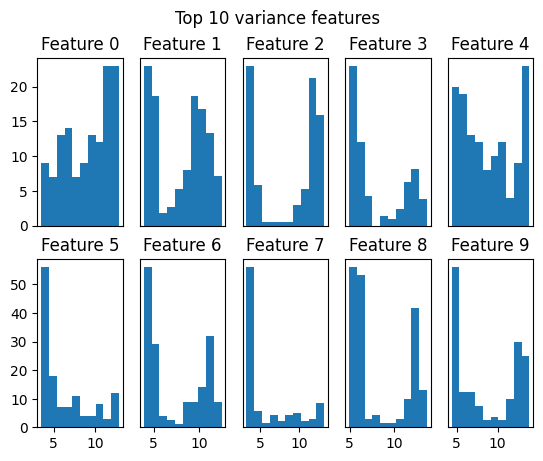

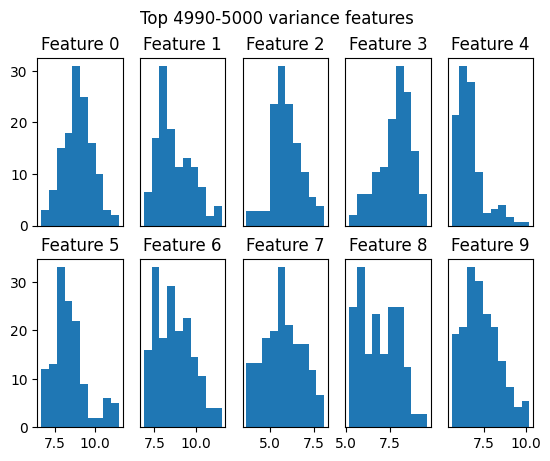

In [ ]:
highest_var_features = np.load('/content/drive/MyDrive/Colab Notebooks/DarthImputer(AutomationProject)/data/brain/brain_5000.npy')
plot_data = highest_var_features[:, -10:]

fig1, ax = plt.subplots(2, 5)
for i in range(10):
  ax[i//5, i%5].hist(plot_data[:, i])
  ax[i//5, i%5].set_title(f'Feature {i}')
  if i//5 != 1: ax[i//5, i%5].set_xticks([])
  if i%5 != 0: ax[i//5, i%5].set_yticks([])

fig1.suptitle('Top 10 variance features')

plot_data = highest_var_features[:, :10]
fig2, ax = plt.subplots(2, 5)
for i in range(10):
  ax[i//5, i%5].hist(plot_data[:, i])
  ax[i//5, i%5].set_title(f'Feature {i}')
  if i//5 != 1: ax[i//5, i%5].set_xticks([])
  if i%5 != 0: ax[i//5, i%5].set_yticks([])

fig2.suptitle('Top 4990-5000 variance features')
plt.show(fig1)
plt.show(fig2)

# 1. Random masking to generate missing data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [ ]:
dataset = 'brain'
i = 1
d = 50
for seed in [0,1,2,3,4]:
  for prop in np.arange(0.05, 0.51, 0.05):
    print(f'{i}/{d}')
    i += 1
    masked_data = helpers.Implement_Random_Masking(highest_var_features, 0.1, prop, seed)
    name = f'{dataset}_{prop:0.2f}_{seed}.npy'
    np.save(f'{root}/data/masked/{dataset}/{name}', masked_data)

# 1.5. Plotting data as heatmap to visualize masking.

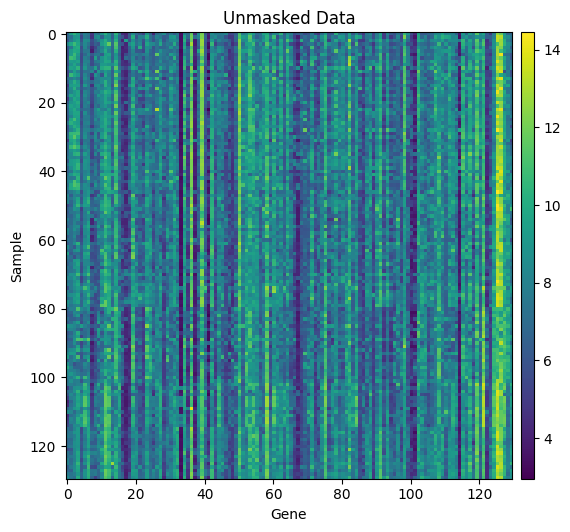

In [ ]:
n_cols = 130 # Number of columns to show.
fig, ax = plt.subplots()
img = ax.imshow(highest_var_features[:, :n_cols])
ax.set_xlabel('Gene')
ax.set_ylabel('Sample')
ax.set_title('Unmasked Data')

fig.subplots_adjust(bottom=0.02, top=0.95, left=0.075, right=0.9,
                    wspace=0.0001, hspace=0.1)
cb_ax = fig.add_axes([0.85, 0.02, 0.02, 0.93])
fig.colorbar(img, cax = cb_ax , fraction=0.036, pad=0.04)
plt.show(fig)


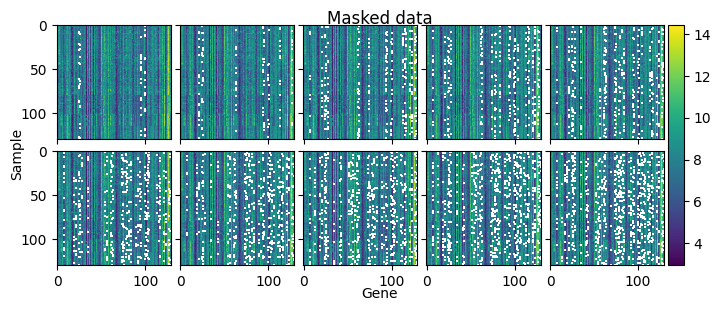

In [ ]:
dataset = 'brain'
fig ,ax = plt.subplots(2, 5, figsize = (7.7,3))

n_cols = 130 # Number of columns to show.

for i, prop in enumerate(np.arange(0.05, 0.51, 0.05)):
  name = f'{dataset}_{prop:0.2f}_0.npy'
  filepath = f'{root}/data/masked/{dataset}/{name}'
  masked_data = np.load(filepath)

  cur_ax = ax[i//5, i%5]
  axs_img_obj = cur_ax.imshow(masked_data[:, :n_cols])
  cur_ax.margins(0)

  if i//5 != 1: cur_ax.set_xticklabels([])
  if i%5 != 0: cur_ax.set_yticklabels([])

fig.subplots_adjust(bottom=0.13, top=0.93, left=0.075, right=0.875,
                    wspace=0.0001, hspace=0.1)
cb_ax = fig.add_axes([0.875, 0.13, 0.02, 0.80])
fig.colorbar(axs_img_obj, cax = cb_ax , fraction=0.036, pad=0.04)
fig.supxlabel('Gene', fontsize = 'medium')
fig.supylabel('Sample', fontsize = 'medium')
fig.suptitle('Masked data', fontsize = 'large')
plt.show(fig)


# 2.1. Simulating MICE performance over 5 generations

In [ ]:
dataset = 'brain'
data = {"features" : highest_var_features, "labels" : all_labels}
parameters_config = {"p_rows" : 0.1, "p_cols": 1}

pipeline = ImputationPipeline.FeatureImputationPipeline(
    method = mice.ImputeDataMice,
    parameters_config = parameters_config,
    data = data,
    loss_func = ImputationPipeline.MSE
)

var = {"p_cols" : np.arange(0.45, 0.51, 0.05)}
res = pipeline.run_multiple_params(num_simuls = 5, variables = var, save_dir= f'{root}/data/mice/{dataset}', method_name='mice')

# 2.2. Simulate Mean performance

In [ ]:
dataset = 'brain'
data = {"features" : highest_var_features, "labels" : all_labels}
parameters_config = {"p_rows" : 0.1, "p_cols": 1}

pipeline = ImputationPipeline.FeatureImputationPipeline(
    method = basic_impute.Imputation_Mean,
    parameters_config = parameters_config,
    data = data,
    loss_func = ImputationPipeline.MSE
)

var = {"p_cols" : np.arange(0.05, 0.51, 0.05)}
res = pipeline.run_multiple_params(num_simuls = 1, variables = var, save_dir= f'{root}/data/mean{dataset}', method_name='mean')

# 2.3. Simulate Mode performance

In [ ]:
dataset = 'brain'
data = {"features" : highest_var_features, "labels" : all_labels}
parameters_config = {"p_rows" : 0.1, "p_cols": 1}

pipeline = ImputationPipeline.FeatureImputationPipeline(
    method = basic_impute.Imputation_Mode,
    parameters_config = parameters_config,
    data = data,
    loss_func = ImputationPipeline.MSE
)

var = {"p_cols" : np.arange(0.05, 0.51, 0.05)}
res = pipeline.run_multiple_params(num_simuls = 1, variables = var, save_dir= f'{root}/data/mode/{dataset}', method_name='mode')

# 2.4 Simulate Custom method performance

In [ ]:
highest_var_features = np.load('/content/drive/MyDrive/Colab Notebooks/DarthImputer(AutomationProject)/data/brain/brain_5000.npy')
labels = np.load('/content/drive/MyDrive/Colab Notebooks/DarthImputer(AutomationProject)/data/brain/labels.npy')

In [ ]:
train_idx = np.load('/content/drive/MyDrive/Colab Notebooks/DarthImputer(AutomationProject)/data/brain/train_indices.npy')
test_idx = np.load('/content/drive/MyDrive/Colab Notebooks/DarthImputer(AutomationProject)/data/brain/test_indices.npy')

In [ ]:
train_x, train_y = data[train_idx], labels[train_idx]
data = {"features" : train_x, "labels" : train_y}
parameters_config = {"p_rows" : 0.1, "p_cols": 0.05}
dataset = 'brain'

pipeline = ImputationPipeline.FeatureImputationPipeline(
    method = expected_risk_imputation.ExpectedRiskImputation(train_y),
    parameters_config = parameters_config,
    data = data,
    loss_func = ImputationPipeline.MSE
)

res, loss = pipeline.run_simulation(0)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 3. Plotting the loss results

In [ ]:
brain_df = ReadData(root, dataset)
all_labels = helpers.EncodeLabels(brain_df['type'].to_numpy())
data = brain_df.iloc[:, 2:].to_numpy() # Numpy arr of the features

proportion = 5000/brain_df.shape[1]
highest_var_features = helpers.HighestVarianceFeatures(data, proportion)

Percentage of explained variance is: 0.38625112722391125


In [ ]:
def GetLoss(filepath, base_data):
  """
  filepath (str): filepath of the imputed data
  base_data (np.ndarray): the
  """
  masked_data = np.load(filepath)
  n_values = masked_data.shape[-1]*masked_data.shape[-2]
  if masked_data.ndim == 3:
    loss = masked_data - base_data[None, ...]
    loss = np.sum(loss**2, axis = (1,2))/n_values
  else:
    loss = masked_data - base_data
    loss = np.sum(loss**2)/n_values
  return loss

In [ ]:
dataset = 'brain'
methods = ['mice', 'mean', 'mode']

for method in methods:
  losses = []
  for i, pcol in enumerate(np.arange(0.05, 0.51, 0.05)):
    name = f'{method}_prow10pcol{100*pcol:02.0f}.npy'
    filepath = f'{root}/data/{method}/{dataset}/{name}'
    loss = GetLoss(filepath, highest_var_features)
    losses.append(loss)
  filepath = f'{root}/data/{method}/{dataset}/losses.npy'
  np.save(filepath, np.array(losses))

In [ ]:
def PlotData(loss, label, fig, ax):
  x = np.arange(0.05, 0.51, 0.05)
  loss = loss.squeeze()
  if loss.ndim == 2:
    handler, = ax.plot(x, loss.sum(axis = 1), alpha = 1, label=label)
    color = handler.get_color()
    ax.errorbar(x, loss.sum(axis = 1), np.std(loss, axis = 1), linestyle ='', capsize = 10)
  else:
    ax.plot(x, loss, alpha = 1, label=label)

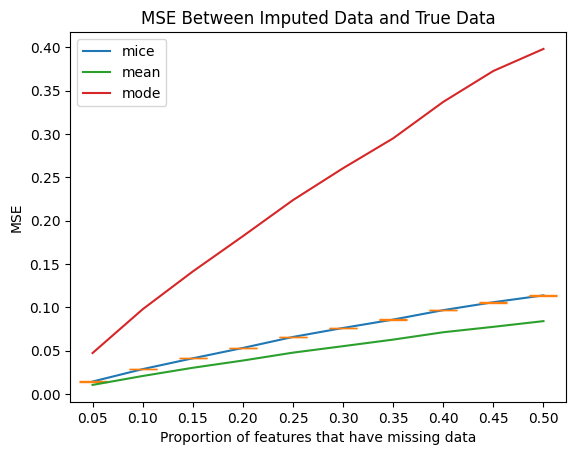

In [ ]:
dataset = 'brain'
methods = ['mice', 'mean', 'mode']

fig, ax = plt.subplots()
for method in methods:
  filepath = f'{root}/data/{method}/{dataset}/losses.npy'
  loss = np.load(filepath)
  PlotData(loss, method, fig, ax)

ax.legend()
ax.set_xlabel('Proportion of features that have missing data')
ax.set_xticks(np.arange(0.05, 0.51, 0.05))
ax.set_ylabel('MSE')
ax.set_title('MSE Between Imputed Data and True Data')
plt.show(fig)

# Test imputed data using multiclass logistic regression as base learner

In [ ]:
import warnings

In [ ]:
highest_var_features = np.load('/content/drive/MyDrive/Colab Notebooks/DarthImputer(AutomationProject)/data/brain/brain_5000.npy')
labels = np.load('/content/drive/MyDrive/Colab Notebooks/DarthImputer(AutomationProject)/data/brain/labels.npy')

In [ ]:
idxs = []
for label in np.unique(labels):
  idxs.append(np.argwhere(labels == label).flatten())

seed = 2024
rng = np.random.default_rng(seed)
for idx_arr in idxs:
  rng.shuffle(idx_arr)

[27 13 17 29 23 11  9 12  5 18 28 43 14  7 19 26 24 45  2  1 44 41 34  0
 30 20 15  3 32 31 10 39 21  4  6 37 38  8 35 42 16 33 36 25 22 40]
[63 76 79 46 71 52 51 72 74 48 62 54 70 56 49 66 61 47 60 68 65 50 69 53
 57 64 77 58 75 67 55 73 78 59]
[ 91  84  80  90  81  92  82  87  85  83  97  89  88  99 100  95 101  96
  86  93  98  94]
[102 109 113 111 107 105 103 112 108 114 110 104 106]
[116 118 129 126 128 124 122 117 127 121 120 119 123 115 125]


In [ ]:
fraction= 0.1
train_idx, test_idx = [], []
for idx_arr in idxs:
  cutoff = round(fraction*len(idx_arr))
  if cutoff == 0: cutoff = 1
  train_idx.extend(idx_arr[:cutoff])
  test_idx.extend(idx_arr[cutoff:])
train_idx = np.array(train_idx)
test_idx = np.array(test_idx)
print(train_idx, '\n', test_idx)

In [ ]:
# train_idx = np.load('/content/drive/MyDrive/Colab Notebooks/DarthImputer(AutomationProject)/data/brain/train_indices.npy')
# test_idx = np.load('/content/drive/MyDrive/Colab Notebooks/DarthImputer(AutomationProject)/data/brain/test_indices.npy')


test_x, test_y = highest_var_features[test_idx], labels[test_idx]
testdata = basemodel.Dataset(test_x, test_y)

train_y = labels[train_idx]

warnings.filterwarnings("ignore", category=UserWarning)

dataset = 'brain'
accuracies = []
for pcol in np.arange(0.05, 0.51, 0.05):
  filepath = f'{root}/data/mice/{dataset}/mice_prow10pcol{100*pcol:02.0f}.npy'
  data = np.load(filepath)
  acc = []
  for i in range(5):
    train_x = data[i, train_idx]
    traindata = basemodel.Dataset(train_x, train_y)
    acc.append(basemodel.BaselineModel(traindata, testdata))
  accuracies.append(acc)

warnings.resetwarnings()

filepath = f'{root}/data/mice/{dataset}/accuracies_{fraction:0.2f}.npy'
np.save(filepath, np.array(accuracies))

In [ ]:
np.load(filepath)

array([[0.82905983, 0.82905983, 0.82905983, 0.82905983, 0.82905983],
       [0.82905983, 0.82905983, 0.82905983, 0.82905983, 0.82905983],
       [0.82905983, 0.82905983, 0.82905983, 0.82905983, 0.82905983],
       [0.82905983, 0.82905983, 0.82905983, 0.82905983, 0.82905983],
       [0.82905983, 0.82905983, 0.82905983, 0.82905983, 0.82905983],
       [0.82905983, 0.82905983, 0.82905983, 0.83760684, 0.82905983],
       [0.82905983, 0.82905983, 0.82905983, 0.82905983, 0.82905983],
       [0.82905983, 0.83760684, 0.82905983, 0.82905983, 0.82905983],
       [0.82905983, 0.82905983, 0.82905983, 0.83760684, 0.82905983],
       [0.82905983, 0.82905983, 0.82905983, 0.82905983, 0.82905983]])

# No idea what this stuff is below

# Base learner

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import mode

# 1. Full dataset

In [ ]:
rf_clf0 = RandomForestClassifier(n_estimators=10, random_state=42)

In [ ]:
rf_clf0.fit(brain_X_train, brain_Y_train)

In [ ]:
pred_0 = rf_clf0.predict(brain_X_test)

In [ ]:
score_0 = accuracy_score(pred_0, brain_Y_test)

In [ ]:
score_0

# 2. 10% masking

In [ ]:
np.random.seed(42)

In [ ]:
X_train_1 = Implement_Random_Masking(brain_X_train, 0.1)

## 2.1. Mean Imputation

In [ ]:
def Imputation_Mean(X):
  '''
  Implement imputation
  '''
  X_imputed = X.copy()
  for col in np.arange(X_imputed.shape[1]):
    col_mean = np.nanmean(X_imputed[:, col])
    X_imputed[np.isnan(X_imputed[:, col]), col] = col_mean
  return X_imputed

In [ ]:
X_imputed_1 = Imputation_Mean(X_train_1)

### 2.1.2. Error compared to the original dataset

In [ ]:
diff1 = mean_squared_error(X_imputed_1, brain_X_train)
diff1

### 2.1.3. Accuracy on test data

In [ ]:
rf_clf1 = RandomForestClassifier(n_estimators=10, random_state=42)
rf_clf1.fit(X_imputed_1, brain_Y_train)
pred_1 = rf_clf1.predict(brain_X_test)
score_1 = accuracy_score(pred_1, brain_Y_test)
score_1

## 2.2. Mode Imputation

In [ ]:
def Imputation_Mode(X):
  '''
  Implement imputation
  '''
  X_imputed = X.copy()
  for col in np.arange(X_imputed.shape[1]):
    unique_values, counts = np.unique(X_imputed[:,col], return_counts=True)
    reverse_sorted_counts = np.argsort(counts)[::-1]
    col_mode = unique_values[0] if unique_values[0] != np.nan else unique_values[1]
    X_imputed[np.isnan(X_imputed[:, col]), col] = col_mode
  return X_imputed

In [ ]:
unique_values, counts = np.unique([np.nan, np.nan, 1,2,3,2,2], return_counts=True)
unique_values, counts

In [ ]:
np.argsort(counts)[::-1]

In [ ]:
X_imputed_mode1 = Imputation_Mode(X_train_1)

### 2.2.2. Error compared to the original dataset

In [ ]:
diff_mode1 = mean_squared_error(X_imputed_mode1, brain_X_train)
diff_mode1

### 2.2.3. Accuracy on test data

In [ ]:
rf_clf1 = RandomForestClassifier(n_estimators=10, random_state=42)
rf_clf1.fit(X_imputed_mode1, brain_Y_train)
pred_mode_1 = rf_clf1.predict(brain_X_test)
score_mode_1 = accuracy_score(pred_1, brain_Y_test)
score_mode_1

In [ ]:
int(3/2)